# TorchScript Bench
Notebook to export models and yolo to TorchScript format to run as expected.

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
PATH_TO_Y_MODEL = os.path.join(os.getcwd(), "..", "weights", "yolo", "train", "weights", "best.pt")
PATH_TO_Y_SCRIPT = os.path.join(
    os.getcwd(), "..", "weights", "yolo", "train", "weights", "best.torchscript")
PATH_TO_M_MODEL = os.path.join(
    os.getcwd(), "..", "weights", "mobile")
FILE_NAME_ROI_MODEL = "mobile_crop.pt"
FILE_NAME_DEC_E_MODEL = "mobile_efficientnet.pt"
FILE_NAME_DEC_S_MODEL = "mobile_shufflenet.pt"
EFF_FILE_PATH = os.path.join(
    os.getcwd(), "..", "weights", "efficientnet_roi_weighted_sampling", 
    "efficientnet", "efficientnet_fold1_2025-06-16_15-05-49.pth")
SHU_FILE_PATH = os.path.join(
    os.getcwd(), "..", "weights", "shufflenet_roi_weighted_sampling",
    "shufflenet", "shufflenet_fold1_2025-06-16_15-09-39.pth")
PATH_TO_IMG = os.path.join(os.getcwd(), "..", "dataset", "Images")

## YOLO Model Conversion
Load the best fine-tuned yolo model and convert it to Torchscript.

In [ ]:
# Imports for the next section
from ultralytics import YOLO
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

from models.export.mobile_model import MobileRoICropModel
from experiments.util import (
    get_random_image, 
    show_pil_image, 
    get_yolo_transform,
    display_tensor_as_image,
    optimize_and_save
)

In [ ]:
# Loading our best model
yolo_model = YOLO(PATH_TO_Y_MODEL)

# Export it as torchscript version
yolo_model.export(format="torchscript", optimize=True, nms=True, batch=1, device="cpu", mode="export")

In [ ]:
# Load back the torchscript version and optimise for mobile devices
scripted_yolo_model = torch.jit.load(PATH_TO_Y_SCRIPT).eval()
scripted_yolo_model = torch.jit.freeze(scripted_yolo_model)
scripted_yolo_model = optimize_for_mobile(scripted_yolo_model)

In [ ]:
# Load the freezed and optimised model into our wrapper model
mobile_roi_crop_model = MobileRoICropModel(scripted_yolo_model)

### Test Wrapper Model
Load an image, with its path and test if it produces the intended result.

In [ ]:
# Load a random image and display the whole image for sanity
img_path, img = get_random_image()
show_pil_image(img)

In [ ]:
# Get transforms, apply and feed it to the model
t = get_yolo_transform()
tensor = t(img)
tensor = tensor.unsqueeze(0)
print(tensor.shape)
cropped = mobile_roi_crop_model(tensor)

In [ ]:
# Display the cropped tensor
display_tensor_as_image(cropped)

### Save the cropping model as torchscript

In [ ]:
# Create the path
full_path = os.path.join(PATH_TO_M_MODEL, FILE_NAME_ROI_MODEL)
print(f"Saving crop model at: {full_path}")
optimize_and_save(mobile_roi_crop_model, full_path, True, True)

## Creating EfficientNet Mobile Model

In [125]:
# Imports needed
import torch
from models.export.mobile_model import MobileDecisionModel
from models.classification.pretrained_models import get_efficientnet_tuned
from experiments.util import (
    resize_and_tensor, 
    optimize_and_save,
    get_random_image,
    display_tensor_as_image,
    get_yolo_transform
)

In [126]:
PATH_TO_CROP_MODEL = os.path.join(PATH_TO_M_MODEL, FILE_NAME_ROI_MODEL)
full_path = os.path.join(PATH_TO_M_MODEL, FILE_NAME_DEC_E_MODEL)

In [127]:
# Load the ROI model for testing
mobile_roi_model = torch.jit.load(PATH_TO_CROP_MODEL)
t = get_yolo_transform()

# Load the decision model
decision_model = get_efficientnet_tuned()
decision_model.load_state_dict(torch.load(EFF_FILE_PATH, map_location="cpu"))
mobile_dec_model = MobileDecisionModel(decision_model, 10)

print(f"Saved model at: {full_path}")
mobile_dec_model = optimize_and_save(mobile_dec_model, full_path, True, True)

Saved model at: /Users/sriharikarthickn/Developer/Projects/dissertation-model/src/experiments/../weights/mobile/mobile_efficientnet.pt


torch.Size([1, 3, 224, 224])


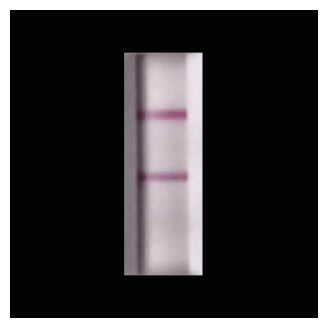

(tensor([0.6573]), tensor([0.]))


In [136]:
img_path, img = get_random_image()
tensor = t(img)
tensor = tensor.unsqueeze(0)
cropped = mobile_roi_model(tensor)
tensor = resize_and_tensor(cropped)
print(tensor.shape)
display_tensor_as_image(tensor)
# Run the model on the new tensor
res = mobile_dec_model(tensor)
print(res)

## Creating ShuffleNet Mobile Model

In [54]:
# Imports needed
import torch
from models.export.mobile_model import MobileDecisionModel
from models.classification.pretrained_models import get_shufflenet_tuned
from experiments.util import (
    resize_and_tensor,
    optimize_and_save,
    get_random_image,
    display_tensor_as_image,
    get_yolo_transform
)

In [55]:
PATH_TO_CROP_MODEL = os.path.join(PATH_TO_M_MODEL, FILE_NAME_ROI_MODEL)
full_path = os.path.join(PATH_TO_M_MODEL, FILE_NAME_DEC_S_MODEL)

In [56]:
# Load the ROI model for testing
mobile_roi_model = torch.jit.load(PATH_TO_CROP_MODEL)
t = get_yolo_transform()

# Load the decision model
decision_model = get_shufflenet_tuned()
decision_model.load_state_dict(torch.load(SHU_FILE_PATH, map_location="cpu"))
mobile_dec_model = MobileDecisionModel(decision_model, 10)
print(f"Saved model at: {full_path}")
mobile_dec_model = optimize_and_save(mobile_dec_model, full_path, True, True)

Saved model at: /Users/sriharikarthickn/Developer/Projects/dissertation-model/src/experiments/../weights/mobile/mobile_shufflenet.pt


torch.Size([1, 3, 224, 224])


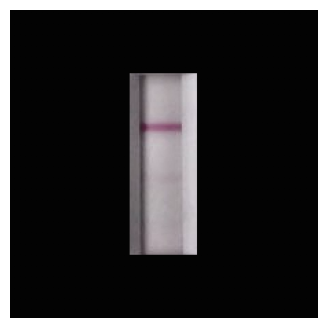

(tensor([0.3849]), tensor([0.]))


In [123]:
img_path, img = get_random_image()
tensor = t(img)
tensor = tensor.unsqueeze(0)
cropped = mobile_roi_model(tensor)
tensor = resize_and_tensor(cropped)
print(tensor.shape)
display_tensor_as_image(tensor)
# Run the model on the new tensor
res = mobile_dec_model(tensor)
print(res)